# Backdoor Unlearning

## Outline

1. Experimental setup (generating configs)
2. Clean model training
3. Poisoned model training
4. First-order unlearning
5. Second-order unlearning
6. Visualizing results


## Experimental Setup

- All configurations to test are defined in the `[train|poison|unlearn].json` files (see below).
- If parameters are passed as list, all their combinations are tested in a grid-search manner.
- Only a single combination is provided for this demo. The original combinations are in `Applications/Poisoning/configs`
- The function generates directories and configuration files for each combination. They are later used by an evaluation script to run the experiment. This allows for parallelization and distributed execution.

In [1]:
import sys
sys.path.append('../')

# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config
from Applications.Poisoning.train import main as train
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment
import pandas as pd
from Applications.Poisoning.evaluate import main as evaluate
from Applications.Poisoning.evaluate import evaluate_and_save_results

ModuleNotFoundError: No module named 'tensorflow'

In [2]:

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

## Clean Model Training

- Set configuration

In [3]:
# train one clean and one poisoned model
dataset = 'Cifar10'
#dataset = 'Cifar100'
# dataset = 'Mnist'
modeltype = "VGG16"
classes= 10
#lasses = 100
#dataset = 'Mnist'

* Train a clean model for reference.

In [4]:
train(model_folder=model_folder/'clean', dataset=dataset, classes=classes, modeltype=modeltype)

In [5]:


clean_folder = model_folder/'clean'
clean_weights_name = dataset+'_'+modeltype+'_best_model.hdf5'
clean_weights = clean_folder/clean_weights_name
evaluate(dataset, modeltype, clean_weights, clean_folder)

2024-06-11 08:07:30.696985: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-11 08:07:30.697013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: conite-HP
2024-06-11 08:07:30.697017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: conite-HP
2024-06-11 08:07:30.697147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 555.42.2
2024-06-11 08:07:30.697163: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-06-11 08:07:30.697166: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 555.42.2
2024-06-11 08:07:30.697425: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.7908


## Train Poisoned Model

- Select one of the generated configurations and train a poisoned model.
- The poisoning uses an `injector` object which can be persisted for reproducibility. It will inject the backdoors/label noise into the same samples according to a seed. In our experiments, we worked with label noise poisoning.

In [6]:

poisoned_folder = model_folder/'budget-10000'/'seed-42'
poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')


In [7]:
train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, dataset=dataset, classes=classes, modeltype=modeltype, train_kwargs=train_kwargs)

In [8]:
poisoned_folder = model_folder/'budget-10000'/'seed-42'
poisoned_weights_name = dataset+'_'+modeltype+'_poisoned_model.hdf5'
poisoned_weights = poisoned_folder/poisoned_weights_name
evaluate(dataset, modeltype, poisoned_weights, poisoned_folder)

Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.6632


In [9]:
weights_name = dataset+'_'+modeltype+'_poisoned_model.hdf5'
fo_repaired_weights_file = dataset+'_'+modeltype+'_repaired_model.hdf5'
so_repaired_weights_file = dataset+'_'+modeltype+'_repaired_model.hdf5'
poisoned_weights = poisoned_folder/weights_name     # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'first-order'/fo_repaired_weights_file   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'second-order'/so_repaired_weights_file   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


## Unlearning

- Perform the first-order and second-order unlearning. The unlearning is wrapped in a function that
    - loads the clean data, saves the original labels
    - injects the poison (label noise)
    - creates difference set Z using `injector.injected_idx`
    - main unlearning happens in `Applications.Poisoning.unlearn.common.py:unlearn_update` and the thereby called `iter_approx_retraining` method
- The variable naming follows the following ideas:
    - `z_x`, `z_y`: features (x) and labels (y) in set `Z`
    - `z_x_delta`, `z_y_delta`: changed features and labels (`z_x == z_x_delta` here and `z_y_delta` contains the original (fixed) labels)
- A word about why iterative:
    - The approximate retraining is configured to unlearn the desired changes in one step.
    - To avoid putting a lot of redundant erroneous samples in the changing set `Z`, the iterative version
        - takes a sub-sample (`prio_idx`) of `hvp_batch_size` in the delta set `Z`
        - makes one unlearning step
        - recalculates the delta set and focuses only on remaining errors
    - The idea here is that similar to learning, it is better to work iteratively in batches since the approximation quality of the inverse hessian matrix decreases with the number of samples included (and the step size)

In [ ]:

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')

fo_experiment(dataset, modeltype, poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs)

In [10]:
# Evaluate the first-order unlearning results
result = evaluate(dataset, modeltype, fo_repaired_weights, poisoned_folder/'first-order')

Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.6712


In [20]:
result

Loading weights from None
Early stopping at iteration 31. Update norm 532091.3710632324 > [526746.9753265381, 20]
Early stopping at iteration 51. Update norm 729301.4430084229 > [440688.9214630127, 20]
Early stopping at iteration 66. Update norm 1564100.2553100586 > [1181221.0216674805, 20]
Early stopping at iteration 83. Update norm 2770689.261352539 > [1470823.1938476562, 20]
Early stopping at iteration 76. Update norm 1278202.006652832 > [1269541.4524536133, 20]
Early stopping at iteration 84. Update norm 3477210.973754883 > [2933188.3520507812, 20]
Early stopping at iteration 148. Update norm 3658277.809326172 > [3342941.490966797, 20]
Early stopping at iteration 105. Update norm 4777600.077880859 > [4402016.154785156, 20]
Early stopping at iteration 124. Update norm 4459100.854125977 > [3703564.2857055664, 20]
Early stopping at iteration 75. Update norm 4557279.100341797 > [4217887.515380859, 20]
Loading weights from None


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

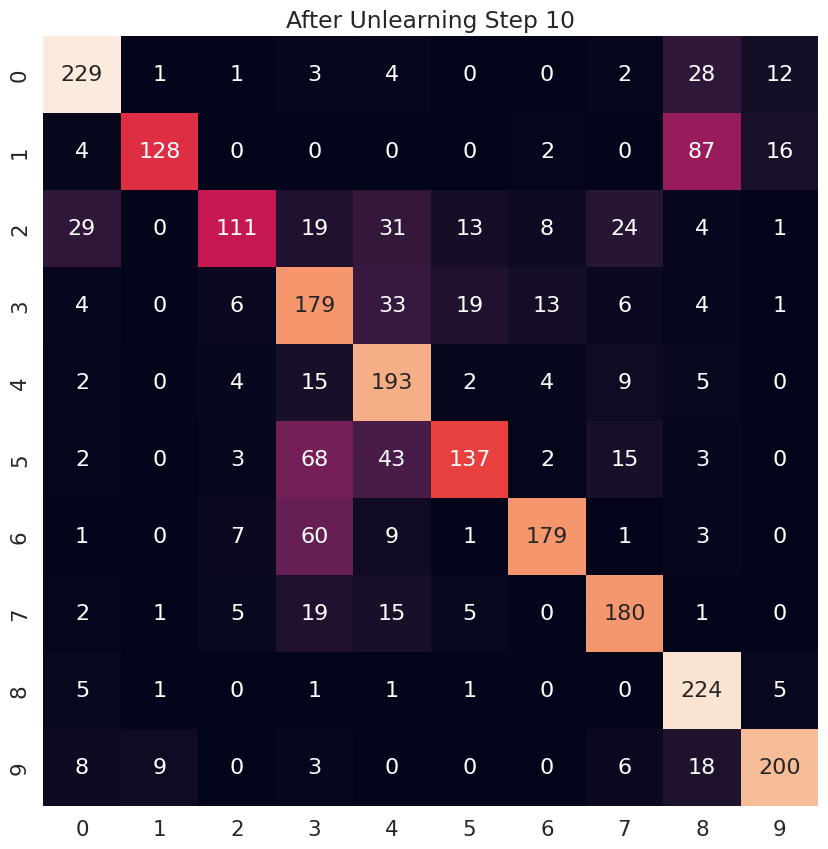

In [16]:
so_experiment(dataset, modeltype, poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs)


In [11]:
# Evaluate the second-order unlearning results
evaluate(dataset, modeltype, so_repaired_weights, poisoned_folder/'second-order')

Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.708


## Visualizing the Results

- To give some notion of how well the unlearning worked, we plot confusion matrices before and after unlearning.
- This is just an example and not required for unlearning.

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

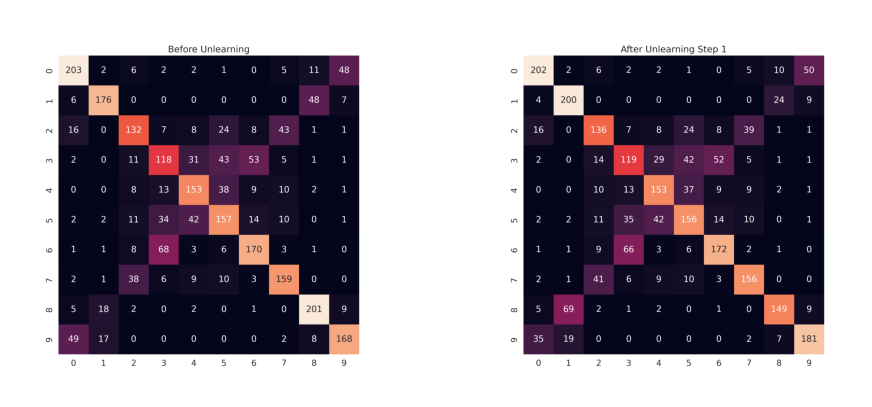

In [18]:
cm_before = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

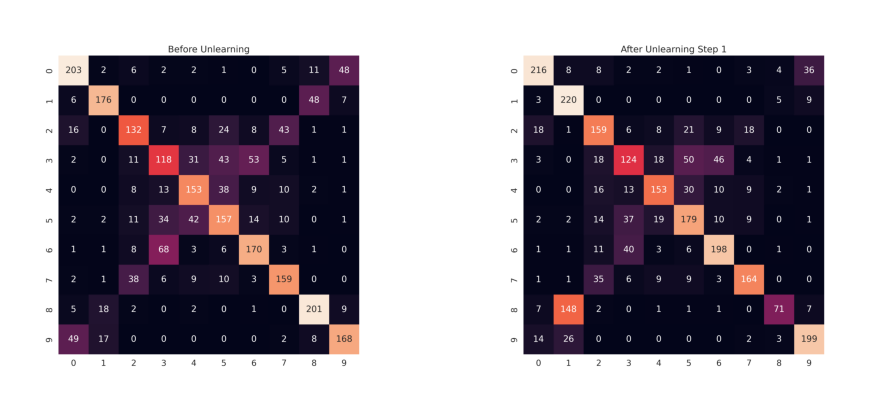

In [19]:
cm_before = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

As you can see, the second-order unlearning is able to fix some of the missing accuracy. However, it can also be observed that the unlearning is not exact in the non-convex setting.

In [11]:
evaluate_and_save_results(dataset, modeltype, clean_weights, poisoned_weights, fo_repaired_weights, so_repaired_weights, BASE_DIR/'Evaluation')

Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.7908
Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.6632
Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.6712
Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.708
Results saved successfully.
   Model  Dataset   Clean  Poisoned  First Update  Second Update
0  VGG16  Cifar10  0.7908    0.6632        0.6712          0.708


In [34]:
# results_fo

### RESNET50

In [3]:

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

modeltype = "RESNET50"
# modeltype = VGG16
# modeltype = ResNet
# train one clean and one poisoned model
dataset = 'Cifar10'
# dataset = 'Cifar100'
# dataset = 'Mnist'
classes = 10
# classes100 = 100

#dataset = 'Mnist'
#train(model_folder=model_folder/'clean', dataset)



## Training clean model(ResNet50)

In [4]:
train(model_folder=model_folder/'clean', dataset=dataset, modeltype=modeltype, classes=classes)

In [5]:
modeltype

'RESNET50'

In [6]:
clean_folder = model_folder/'clean'
clean_weights_name = dataset+'_'+modeltype+'_best_model.hdf5'
clean_weights = clean_folder/clean_weights_name
evaluate(dataset, modeltype, clean_weights, clean_folder)

2024-06-11 08:33:27.441227: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-11 08:33:27.441267: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: conite-HP
2024-06-11 08:33:27.441276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: conite-HP
2024-06-11 08:33:27.441405: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 555.42.2
2024-06-11 08:33:27.441435: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-06-11 08:33:27.441442: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 555.42.2
2024-06-11 08:33:27.441799: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.6544


## Train Poisoned Model


In [7]:
poisoned_folder = model_folder/'budget-10000'/'seed-42'
poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')
train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, train_kwargs=train_kwargs, dataset=dataset, modeltype="RESNET50", classes=classes)


In [8]:
poisoned_folder = model_folder/'budget-10000'/'seed-42'
poisoned_weights_name = dataset+'_'+modeltype+'_poisoned_model.hdf5'
poisoned_weights = poisoned_folder/poisoned_weights_name
evaluate(dataset, modeltype, poisoned_weights, poisoned_folder)

Loading weights from None
Model weights loaded successfully.
Accuracy Cifar10 model: 0.442


In [9]:
poisoned_weights = poisoned_folder/'best_model.hdf5'       # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'fo_repaired.hdf5'   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'so_repaired.hdf5'   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset

In [10]:
weights_name = dataset+'_'+modeltype+'_poisoned_model.hdf5'
fo_repaired_weights_file = dataset+'_'+modeltype+'_repaired_model.hdf5'
so_repaired_weights_file = dataset+'_'+modeltype+'_repaired_model.hdf5'
poisoned_weights = poisoned_folder/weights_name     # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'first-order'/fo_repaired_weights_file   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'second-order'/so_repaired_weights_file   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


In [11]:

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')

Loading weights from None


TypeError: in user code:

    File "../Applications/Poisoning/unlearn/core.py", line 60, in get_gradients_diff  *
        loss_x = model.loss(y_tensor[start:start + batch_size], result_x)

    TypeError: 'str' object is not callable


<Figure size 640x480 with 0 Axes>

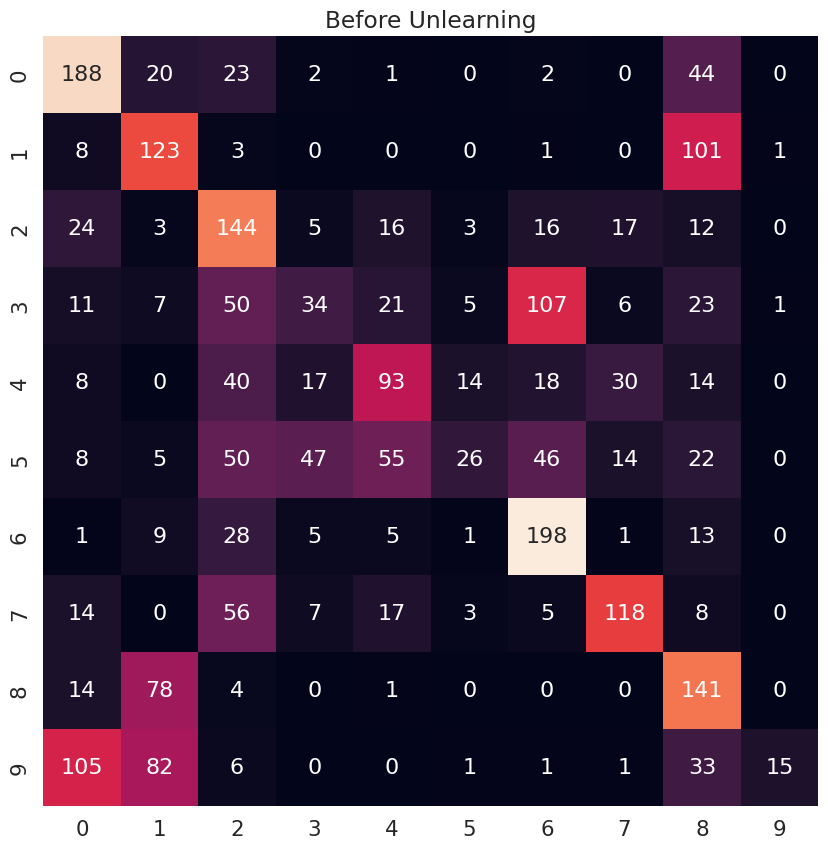

In [12]:
fo_experiment(dataset, modeltype,  poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs)

In [ ]:
so_experiment(dataset, modeltype,poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs, classes=classes)

In [ ]:



# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8


cm_before = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()



In [ ]:

cm_before = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()
